## **Problem Statement**

**DOMAIN:** Industrial safety. NLP based Chatbot.

**CONTEXT:** The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

**DATA DESCRIPTION:** This  The  database  is  basically  records  of  accidents  from 12  different  plants  in  03  different  countries which  every  line  in  the  data  is  an occurrence of an accident.

  **Columns description:**
   - Data: timestamp or time/date information
   - Countries: which country the accident occurred (anonymised)
   - Local: the city where the manufacturing plant is located (anonymised)
   - Industry sector: which sector the plant belongs to
   - Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
   - Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
   - Genre: if the person is male of female
   - Employee or Third Party: if the injured person is an employee or a third party
   - Critical Risk: some description of the risk involved in the accident
   - Description: Detailed description of how the accident happened.

**PROJECT OBJECTIVE:** Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident description.

## **Importing the necessary libraries**

In [ ]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to use regular expressions for manipulating text data
import re

# Importing the SpaCy library
import spacy
nlp = spacy.load('en_core_web_sm')    # loading the envrionment config

# To create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# To create TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# To plot confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

# To use various metrics from sklearn
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# To visualize data

import holoviews as holoviews
from holoviews import opts

import math

## **Loading the dataset**

In [ ]:
# Mount the google drive
from google.colab import drive
try:
  drive.mount('/content/drive') # Mounts your Google Drive
except Exception as e:
  print(f"Error mounting Google Drive: {e}")
  print("Please try running the cell again. If the error persists, you may need to re-authenticate your Google account.")

In [ ]:
# loading data into a pandas dataframe
accidents_data = pd.read_excel("/content/industrial_safety_and_health_database_with_accidents_description.xlsx")
#accidents_data = pd.read_excel("https://raw.githubusercontent.com/ABHINAVRISHI1983/nlp-chat-bot/main/industrial_safety_and_health_database_with_accidents_description.xlsx", engine='openpyxl')

In [ ]:
# creating a copy of the data
data = accidents_data.copy() #Good practice to preserve raw data

## **Data Overview**

### Checking the first five rows of the data

In [ ]:
# Display top 5 rows
data.head(5)

In [ ]:
# Drop unnamed cols as it seems more like index or S.No
data.drop(columns=[col for col in data.columns if "Unnamed" in col], inplace=True)

In [ ]:
# Display top 5 rows after dropping
data.head(5)

- All records in the Description column are detailed and natural language-based.
- Potential Accident Level - ordinal classification target, looks like it is ranging from I to IV
- Critical Risk - could be multi-class or multi-label target.
-Countries, Local, Industry Sector, Genre, Employee or Third Party, Critical Risk Have limited number of categories, Could be one-hot encoded or embedded later


In [ ]:
data.info()

- Data is datetime column
- All other columns are of type Object
- Countries, Local, Industry Sector are Categorical columns used for Geographic distribution of accidents, Industry-wise accident risk profiling
- Accident Level is Target candidate
- Genre is Likely binary (Male, Female)
- Employee or Third Party is categorical with values "Employee", "Third Party", "Third Party (Remote)"
- Critical Risk is Multi-class categorical that represents accident cause or risk factor
- Description is original accident text (rich, unstructured), can be used for NLP and Risk pattern mining

In [ ]:
data['Accident Level'].value_counts()

- There are 6 Accident levels

In [ ]:
data['Description'].str.len().describe()

- On average, each description is about 365 characters long
- Some are very short, some quite long with min being 94 chars and max being 1029 chars
- 25% of descriptions are shorter than 225 characters
- Median length is 334 characters — close to the mean
- 75% of the descriptions are under 453 characters
- The longest description is over 1000 characters (very detailed)

### Checking the shape of the dataset

In [ ]:
#check shape of dataset
data.shape

* The dataset has 425 rows and 10 columns.

### Checking for Missing Values

In [ ]:
#check for missing values
data.isnull().sum()

* There are no missing values in the data

### Checking for duplicate values

In [ ]:
# checking for duplicate values
data.duplicated().sum()

- There are 7 duplicate rows

In [ ]:
# Drop duplicate rows
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
# Confirm removal
print(f"Duplicates in current dataset - {data.duplicated().sum()}")
print(f"New shape after removing duplicates: {data.shape}")

* The dataset has 418 rows and 10 columns after dropping the duplicates

## **Data Preprocessing**

### **Removing special characters**

In [ ]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = re.sub(pattern, ' ', text)

    return new_text

In [ ]:
# Applying the function to remove special characters
data['cleaned_text'] = data['Description'].apply(remove_special_characters)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Description','cleaned_text']]

- We can observe that regex removed the special characters ilike comma (,), equals (=), slash (/), Hiphen (-) etc.,

### **Lowercasing**

In [ ]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Description','cleaned_text']]

- We can observe that all the text has now successfully been converted to lower case.

### **Removing extra whitespace**

In [ ]:
# Count rows with 2+ consecutive spaces
data['Description'].apply(lambda x: bool(re.search(r'\s{2,}', str(x)))).sum()

- There are no extra spaces found, so no need to strip the spaces, still better to have the step for any future data

In [ ]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

### **Lemmatization**

In [ ]:
def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_space and not token.is_stop
    ])

In [ ]:
# Apply on cleaned_text (not the one with stopwords already removed)
data['final_cleaned_text'] = data['cleaned_text'].apply(spacy_lemmatize)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:2, ['Description', 'cleaned_text', 'final_cleaned_text']]


We can see that the below sample words and corresponding word after applying lemmatization, This look much better that porter stemming

- removing -> remove
- proceeds -> proceed
- seeing -> see
- supports -> support

##**EDA**

In [ ]:
#Create a copy for EDA analysis
data_eda=data.copy()

### **Extract Day/Month/Year/WeekDay/WeekofYear from the Data**

In [ ]:
data_eda['Year'] = data_eda.Data.apply(lambda x : x.year).astype(int)
data_eda['Month'] = data_eda.Data.apply(lambda x : x.month_name())
data_eda['Day'] = data_eda.Data.apply(lambda x : x.day)
data_eda['Weekday'] = data_eda.Data.apply(lambda x : x.day_name())
data_eda['WeekofYear'] = data_eda.Data.apply(lambda x : x.weekofyear)
data_eda["DayOfWeek"] = data_eda["Data"].dt.day_name()

###**Univariate Analysis**

####**Industry Sector**

In [ ]:
ax = sns.countplot(data=data_eda, x="Industry Sector", stat="percent")
plt.ylabel("Percentage")
plt.xlabel("Industry Sector")
# Add percentage labels inside bars
for p in ax.patches:
    percentage = f'{p.get_height():.1f}%'  # format with 1 decimal
    ax.text(
        p.get_x() + p.get_width() / 2.,  # x-position (center of bar)
        p.get_height() / 2.,             # y-position (middle of bar)
        percentage,
        ha='center', va='center', color='white', fontsize=11, fontweight='bold'
    )

plt.show();

**Observation:**

*  Mining industry has highest percentage of accidents which is 56.7 %.
*  Metals has 30.6% accidents.
*  Others  has 10.4% of accidents.

####**Country**

In [ ]:
ax = sns.countplot(data=data, x="Countries", stat="percent")
plt.ylabel("Percentage")
plt.xlabel("Countries")
# Add percentage labels inside bars
for p in ax.patches:
    percentage = f'{p.get_height():.1f}%'  # format with 1 decimal
    ax.text(
        p.get_x() + p.get_width() / 2.,  # x-position (center of bar)
        p.get_height() / 2.,             # y-position (middle of bar)
        percentage,
        ha='center', va='center', color='white', fontsize=11, fontweight='bold'
    )

plt.show();

**Observation:**

- Country_01 has highest percentage of accidents which is 59.1 %.
- Country_02 has 30.6% accidents.
- Country_03 has 10.4% of accidents.


####**Local**

In [ ]:
local_cnt = np.round(data_eda['Local'].value_counts(normalize=True) * 100)

holoviews.extension('bokeh')
holoviews.Bars(local_cnt).opts(title="Local Count", color="#8888ff", xlabel="Locals", ylabel="Percentage", yformatter='%d%%')\
                .opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

**Observation:**

* Local_03 has highest number of accidents.

####**Genre**

In [ ]:
local_cnt = np.round(data_eda['Genre'].value_counts(normalize=True) * 100)
holoviews.extension('bokeh')
holoviews.Bars(local_cnt).opts(title="Genre Count", color="#8888ff", xlabel="Genre", ylabel="Percentage", yformatter='%d%%')\
                .opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

**Observation:**

* Accidents are disproportionately higher among males compared to females.

####**Employee or Third Party**

In [ ]:
local_cnt = np.round(data_eda['Employee or Third Party'].value_counts(normalize=True) * 100)
holoviews.extension('bokeh')
holoviews.Bars(local_cnt).opts(title="Employee Type Count", color="#8888ff", xlabel="Employee Type", ylabel="Percentage", yformatter='%d%%')\
                .opts(opts.Bars(width=500, height=600,tools=['hover'],show_grid=True))

**Observation:**
* There is not much of a difference between Third Party workers and Employees in the incident report.

####**Critical Risk**

In [ ]:
holoviews.extension('bokeh')


# Compute percentages and sort descending
local_cnt = np.round(data_eda['Critical Risk'].value_counts(normalize=True) * 100).sort_values(ascending=False)

# Horizontal bar chart
bars = holoviews.Bars(local_cnt)

bars.opts(
    title="Critical Risk Count",
    color="green",
    width=800, height=800,   # taller for many categories
    tools=['hover'],
    show_grid=True,
    invert_axes=True,        # horizontal bars
    xlabel="Percentage",
    ylabel="Critical Risk Type",
    xformatter='%d%%',
    fontsize={'ylabel': '10pt', 'xlabel': '10pt', 'xticks': '9pt', 'yticks': '8pt'}
)

**Observation:**

* 'Others’ category has the most entries, indicating that the critical-risk taxonomy and reporting process are inadequate—most on-site incidents don’t fit the current categories

####**Data**

In [ ]:
# build counts
df_year = (data_eda["Data"].dt.year
           .value_counts()
           .sort_index()
           .rename_axis("Year")
           .reset_index(name="Count"))

# make Year a *categorical* (ordered) so axis shows 2016, 2017, ... (no decimals)
df_year["Year"] = pd.Categorical(
    df_year["Year"].astype(str),              # strings => discrete axis
    categories=df_year["Year"].astype(str).tolist(),
    ordered=True
)

by_year = holoviews.Bars(
    df_year, kdims="Year", vdims='Count'
).opts(
    title="By Year", xlabel="Year", ylabel="Count",
    width=420, height=300, show_grid=True, color="#1f77b4"
)

# Month order
months = ["January","February","March","April","May","June",
          "July","August","September","October","November","December"]

df_month = (data_eda["Data"].dt.month_name()
            .value_counts()
            .reindex(months, fill_value=0)
            .rename_axis("Month")
            .reset_index(name="Count"))

# Make categorical with explicit order
df_month["Month"] = pd.Categorical(df_month["Month"], categories=months, ordered=True)

by_month = holoviews.Bars(
    df_month, kdims="Month", vdims="Count"
).opts(
    title="By Month",
    xlabel="Month", ylabel="Count",
    width=600, height=300, xrotation=45,
    show_grid=True, color="#2ca02c"
)
# Weekday order
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

df_dow = (data_eda["Data"].dt.day_name()
          .value_counts()
          .reindex(weekdays, fill_value=0)
          .rename_axis("Day")
          .reset_index(name="Count"))

df_dow["Day"] = pd.Categorical(df_dow["Day"], categories=weekdays, ordered=True)

by_dow = holoviews.Bars(
    df_dow, kdims="Day", vdims="Count"
).opts(
    title="By Day of Week",
    xlabel="Day", ylabel="Count",
    width=600, height=300,
    show_grid=True, color="#ff7f0e"
)

(by_year + by_month + by_dow).cols(3)

**Observation:**

**By Year** → Most incidents occurred in 2016, with a drop in 2017.

**By Month** → Incidents are fairly spread across months, with peak in February and higher overall in 1st half of the year

**By Day of Week** → Incidents occur throughout the week, slightly higher on Thursdays.

####**Weekly Incidents**

In [ ]:
ax = (data_eda.set_index('Data')
           .resample('W').size()              # weekly row count
           .rename('Incidents per week')
           .plot())

ax.set_title('Weekly incidents')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

**Observation:**

* Counts fluctuate a lot week to week (mostly 2–8), with a few spikes to 10–12.

* No clear upward or downward trend across 2016–mid-2017.

* Clusters of higher activity appear in early 2016 and early 2017.

* Quieter periods around late 2016 and Apr–May 2017.

###**Bivariate Analysis**

####**Weekly incidents by Industry Sector**

In [ ]:
# Ensure datetime
data_eda["Data"] = pd.to_datetime(data_eda["Data"])

# Weekly counts by industry
weekly = (data_eda.set_index("Data")
              .groupby("Industry Sector")
              .resample("W").size()
              .unstack(0)
              .fillna(0))

# ---- Side-by-side small multiples ----
industries = weekly.columns.tolist()
n = len(industries)
ncols = min(3, n)                 # up to 3 across; adjust as you like
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5*ncols, 3*nrows),   # width x height per panel
    sharex=True, sharey=True
)
axes = np.atleast_1d(axes).ravel()

for ax, col in zip(axes, industries):
    weekly[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")             # keep global x-label
    ax.set_ylabel("Count")

# remove any unused axes
for ax in axes[n:]:
    fig.delaxes(ax)

fig.suptitle("Weekly incidents by Industry Sector", y=0.995, fontsize=12)
plt.tight_layout()
plt.show()

**Observation:**

* Mining shows the highest and most sustained weekly activity (baseline ~2–4/week, spikes to ~6–8), with a slight uptick in early 2017.

* Metals is bursty: frequent small spikes (≤5) and more zero weeks than Mining.

* Others is sparse, with long zero stretches and a few isolated spikes (mid-2016, early 2017).


####**Year Data country wise**

In [ ]:
data_eda['Data'] = pd.to_datetime(data_eda['Data'])

# daily counts per country
daily = (data_eda.groupby(['Data','Countries'])
                 .size()
                 .unstack('Countries')
                 .fillna(0))

# optional: smooth to weekly sums
weekly = daily.resample('W').sum()

ax = weekly.plot(figsize=(15,4))   # one line per country
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Date'); plt.ylabel('Count'); plt.title('Events per Country (weekly)')

**Observation:**

*  **Country_01** leads consistently (often 3–6/week, peaks ~8).

*  **Country_02** is sporadic: many zeros with bursts (1–3, occasional 4–5).

*  **Country_03** is mostly zero with rare spikes (max ~6 around mid-2016).

*  No clear trend/seasonality across 2016–mid-2017—peaks are episodic.

*  **High volatility** week to week for all countries.

####**Country wise Industry Sector**

In [ ]:
# Assume df has 'Countries' and 'Industry Sector'
# Count incidents by Country & Sector
counts = data_eda.groupby(['Countries', 'Industry Sector']).size().reset_index(name='Count')

# Make a grouped bar chart
bars = holoviews.Bars(counts, kdims=['Countries', 'Industry Sector'], vdims='Count').opts(
    title="Incidents by Country and Industry Sector",
    width=900, height=500,
    stacked=False,            # False = grouped, True = stacked
    tools=['hover'],
    show_grid=True,
    legend_position='right',
    xrotation=45
)

bars

**Observations**

**Country 1** → Incidents mainly from Mining (~80%).

**Country 2**→ Incidents dominated by Metals (~70%).

**Country 3** → Almost entirely Others (~100%).

Sector contribution is country-specific, not uniform.

####**Industry wise Accident Level**

In [ ]:
accident_order={'I':1, 'II':2, 'III':3, 'IV':4, 'V':5}
fig=sns.FacetGrid(data,aspect=1.2,palette="winter",col='Industry Sector', legend_out=True)
fig.map(sns.countplot, 'Accident Level', order=accident_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**Observation:**

* Level I dominates in all sectors.

* Males account for the vast majority of incidents across every level; female cases are few and mostly Level I.

* Severe levels (III–V) occur mainly in Mining and Metals; Others has low volume and no Level V.

* Mining shows the highest overall counts, followed by Metals; Others is minimal.

####**Industry wise  Potential Accident Level**

In [ ]:
accident_order={'I':1, 'II':2, 'III':3, 'IV':4, 'V':5}
fig=sns.FacetGrid(data,aspect=1.2,palette="winter",col='Industry Sector', legend_out=True)
fig.map(sns.countplot, 'Potential Accident Level', order=accident_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**Observation:**

* **Mining** industry has the **highest number of potential accidents**, especially at Level IV.

* **Metals** industry shows accidents spread across Levels II–IV, but with lower counts than Mining.

* **Others** category has very few accidents, mostly at Level I.

* In short: Mining is the riskiest sector, with most serious accidents (Level IV), while Metals and Others face fewer and lower-level accidents.

####**Critical Risk Vs Accident Level**

In [ ]:
acc_cr = data_eda.pivot_table(index='Critical Risk',
                          columns='Accident Level',
                          aggfunc='size')

acc_cr = acc_cr.fillna(0).astype(int)        # convert to int if counts
acc_cr['total'] = acc_cr.sum(axis=1)

acc_cr.style.background_gradient(cmap='Blues')

**Observation:**

* “Others” dominates with 232 incidents—far above the next categories (Pressed 24, Manual Tools 20, Chemical substances 17). This signals a taxonomy/reporting gap.

* Severity mix: Level I incidents are the majority across categories; Level IV–V are rare overall.

**Where severe cases appear:**

* Others: highest absolute severe count (IV=13, V=3) due to volume.

* Power lock: 2 of 3 are Level V → very high severity rate.

* Pressed: notable Level IV = 4.

* Fall: has Level IV/V entries—needs attention.

####**Critical Risk Vs Potential Accident  Level**

In [ ]:
acc_cr = data.pivot_table(index='Critical Risk',
                          columns='Potential Accident Level',
                          aggfunc='size')

acc_cr = acc_cr.fillna(0).astype(int)        # convert to int if counts
acc_cr['total'] = acc_cr.sum(axis=1)

acc_cr.style.background_gradient(cmap='Blues')

**Observation:**

* Biggest bucket: Others (232) — too broad; reclassify to act on it.

* Highest specific totals: Pressed (24), Manual Tools (20), Chemical substances (17).

* Severe-heavy risks (IV–V): Vehicles/Mobile Equipment (IV=2, V=4), Power lock (V=3), Projection (IV=7, V=2), Pressed (IV=7, V=1), Suspended Loads (IV=5), Fall prevention (IV=5).

* Mostly low severity: Bees (all I=10), Venomous Animals (mainly I=13), Manual Tools (peaks at II–III), Cut (II–III).

* Notable singles: Level VI appears once (Remains of choco).

####**Critical Risk Vs Industry Sector**

In [ ]:
industry_cr = data_eda.pivot_table(index='Critical Risk',
                          columns='Industry Sector',
                          aggfunc='size')

industry_cr = industry_cr.fillna(0).astype(int)        # convert to int if counts
industry_cr['total'] = industry_cr.sum(axis=1)

industry_cr.style.background_gradient(cmap='Blues')

**Observation:**

* Mining has the most incidents, mainly due to a very large “Others” count (179).

* Metals is second; top risks here are Pressed (17), Chemical substances (15), and Manual tools (14).

* Others sector is small but skewed to animal/insect hazards: Venomous animals (13) and Bees (10).

####**Genre Vs Industry Sector**

In [ ]:
# Assume df has 'Genre' and 'Industry Sector'
# Count incidents by Genre & Sector
counts = data_eda.groupby(['Genre', 'Industry Sector']).size().reset_index(name='Count')

# Make a grouped bar chart
bars = holoviews.Bars(counts, kdims=['Genre', 'Industry Sector'], vdims='Count').opts(
    title="Incidents by Genre and Industry Sector",
    width=900, height=500,
    stacked=False,            # False = grouped, True = stacked
    tools=['hover'],
    show_grid=True,
    legend_position='right',
    xrotation=45
)


bars


**Observation:**

* Most incidents are among males, especially in the Mining sector (highest count).

* Metals (male) also shows a significant number of incidents.

* Females have very few incidents across all sectors.

* “Others” sector has a moderate number of incidents, mainly among males.

* In short: Mining (males) dominates incident counts in all sectors(Mining/Metals/Others), while female incidents are minimal.

## **Model Training**

In [ ]:
# Pre Settings common for all models
RANDOM_STATE = 42

### **Split train & test**

In [ ]:
from sklearn.model_selection import train_test_split

# Define features & labels
X = data['final_cleaned_text'].values
y = data['Accident Level'].values

#Split train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


### Define vectorizers (BoW and TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, sublinear_tf=True)

### Define evaluation function

In [ ]:
# Shared results list -> final DF for comparison
RESULTS = []

In [ ]:
from collections import Counter

#To Show Class imbalance
def show_class_balance(y_vec, title="Class balance"):
    cnt = Counter(y_vec)
    total = sum(cnt.values())
    df = pd.DataFrame({
        "Class": list(cnt.keys()),
        "Count": list(cnt.values()),
        "Percent": [round(100*v/total, 2) for v in cnt.values()]
    }).sort_values("Count", ascending=False).reset_index(drop=True)
    print(title)
    display(df)
    return df

In [ ]:
def evaluate_and_log(model, Xtr, ytr, Xte, yte, label, results_list, show_cm=True):
    # Train the model
    model.fit(Xtr, ytr)

    # Predictions
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)

    # Metrics
    train_acc = accuracy_score(ytr, ytr_pred)
    test_acc  = accuracy_score(yte, yte_pred)
    test_f1   = f1_score(yte, yte_pred, average="macro", zero_division=0)

    # Print report
    print(f"\n{label} Results")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test  Accuracy: {test_acc:.3f}")
    print(f"Test  Macro-F1: {test_f1:.3f}\n")
    print(classification_report(yte, yte_pred, digits=3, zero_division=0))

    # Confusion matrix
    if show_cm:
        classes = np.unique(yte)
        cm = confusion_matrix(yte, yte_pred, labels=classes)
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=classes, yticklabels=classes,
                    cmap="Blues")
        plt.title(f"{label} - Confusion Matrix")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()

    # Append to results list with consistent keys
    results_list.append({
        "Model": label,
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Test Macro-F1": round(test_f1, 3)
    })


### Check class imbalance

In [ ]:
_ = show_class_balance(y, title="Overall class balance")

- The class imbalance is very high across classes

In [ ]:
_ = show_class_balance(y_train, title="Train split balance")

In [ ]:
_ = show_class_balance(y_test,  title="Test split balance")

- Our dataset was heavily imbalanced, with ~74% of accidents labeled as Level I while severe cases (Levels III, IV and V) had fewer than 10 examples.
- Without balancing, models tended to predict only the majority class, leading to high accuracy but poor macro-F1.
- Apply Random Oversampling on the training data to give minority classes equal representation, ensuring the model could also learn patterns from rare but critical severe accidents

### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=RANDOM_STATE)

### Train AdaBoost with BoW

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline


# Base (weak) learner with class_weight to help skew
weak_learner = DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=RANDOM_STATE)

ada_params = dict(estimator=weak_learner, n_estimators=200, learning_rate=0.5, random_state=RANDOM_STATE)

# Pipelines
ada_bow_plain = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", AdaBoostClassifier(**ada_params))
])

In [ ]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(ada_bow_plain,  X_train, y_train, X_test, y_test, "AdaBoost (BoW)", RESULTS)

In [ ]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(ada_tfidf_plain,X_train, y_train, X_test, y_test, "AdaBoost (TF-IDF)", RESULTS)

In [ ]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(ada_bow_overs,  X_train, y_train, X_test, y_test, "AdaBoost (BoW + Oversample)", RESULTS)

In [ ]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(ada_tfidf_overs,X_train, y_train, X_test, y_test, "AdaBoost (TF-IDF + Oversample)", RESULTS)

In [ ]:
# Compare Results
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

### Hyper-parameter tuning

In [ ]:
#utility method to build base pipeline
def build_ada_pipeline(vectorizer):
    return ImbPipeline([
        (vectorizer.__class__.__name__.lower(), vectorizer),
        ("oversample", sampler),  # keep in-CV balancing
        ("clf", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE),
            random_state=RANDOM_STATE
        ))
    ])

In [ ]:
# Hyper Parameters to be tuned
ada_grid = {
    "clf__n_estimators":  [100, 200, 400],
    "clf__learning_rate": [0.1, 0.3, 0.5, 1.0],
    "clf__estimator__max_depth": [1, 2],
    "clf__estimator__min_samples_leaf": [1, 2]
}

#### Hyper parameter tuning for Bow

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define a stratified 5-fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
from sklearn.model_selection import GridSearchCV


# Build the AdaBoost pipeline using Bag-of-Words features
pipe_bow   = build_ada_pipeline(bow_vectorizer)

# Set up GridSearchCV for hyperparameter tuning
grid_bow = GridSearchCV(
    estimator=pipe_bow,
    param_grid=ada_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"  # fail fast if something is wrong
)

# Run the grid search on the training data
grid_bow.fit(X_train, y_train)

print("Best BoW params:", grid_bow.best_params_, "CV Macro-F1:", round(grid_bow.best_score_, 3))


#### Hyper parameter tuning for TF-IDF

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Build the AdaBoost pipeline using TDIDF features
pipe_tfidf = build_ada_pipeline(tfidf_vectorizer)

# Set up GridSearchCV for hyperparameter tuning
grid_tfidf = GridSearchCV(
    estimator=pipe_tfidf,
    param_grid=ada_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)

# Run the grid search on the training data
grid_tfidf.fit(X_train, y_train)

print("Best TF-IDF params:", grid_tfidf.best_params_, "CV Macro-F1:", round(grid_tfidf.best_score_, 3))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best TF-IDF params: {'clf__estimator__max_depth': 2, 'clf__estimator__min_samples_leaf': 2, 'clf__learning_rate': 1.0, 'clf__n_estimators': 400} CV Macro-F1: 0.698



AdaBoost (BoW + TUNED) Results
Train Accuracy: 0.922
Test  Accuracy: 0.619
Test  Macro-F1: 0.236

              precision    recall  f1-score   support

           I      0.746     0.806     0.775        62
          II      0.111     0.125     0.118         8
         III      0.000     0.000     0.000         6
          IV      1.000     0.167     0.286         6
           V      0.000     0.000     0.000         2

    accuracy                          0.619        84
   macro avg      0.371     0.220     0.236        84
weighted avg      0.633     0.619     0.604        84



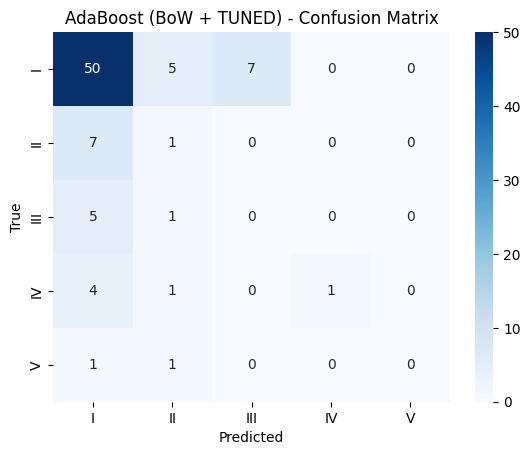

In [ ]:
#Evaluate AdaBoost with BoW + Tuned
_ = evaluate_and_log(grid_bow.best_estimator_,   X_train, y_train, X_test, y_test,
                     "AdaBoost (BoW + TUNED)", RESULTS)


AdaBoost (TF-IDF + TUNED) Results
Train Accuracy: 0.964
Test  Accuracy: 0.619
Test  Macro-F1: 0.158

              precision    recall  f1-score   support

           I      0.743     0.839     0.788        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.619        84
   macro avg      0.149     0.168     0.158        84
weighted avg      0.548     0.619     0.582        84



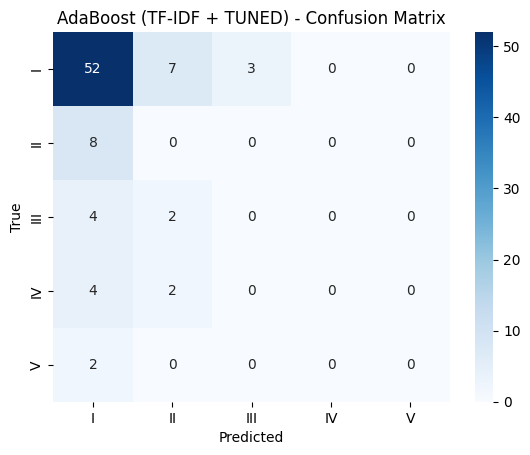

In [ ]:
#Evaluate AdaBoost with TF-IDF + Tuned
_ = evaluate_and_log(grid_tfidf.best_estimator_, X_train, y_train, X_test, y_test,
                     "AdaBoost (TF-IDF + TUNED)", RESULTS)

In [ ]:
#Compare results
final_df = pd.DataFrame(RESULTS).sort_values(["Test Accuracy"], ascending=False).reset_index(drop=True)
display(final_df)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
2,AdaBoost (TF-IDF + TUNED),0.964,0.619,0.158
3,AdaBoost (BoW + TUNED),0.922,0.619,0.236
4,AdaBoost (TF-IDF + Oversample),0.719,0.571,0.254
5,AdaBoost (BoW + Oversample),0.581,0.452,0.253


- Based on Accuracy, AdaBoost (BoW / TF-IDF base) seems better (0.738) along with AdaBoost (BoW)

### SVM Model Starts

In [ ]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline

# Define SVM model
svm = SVC(kernel='poly', degree=3, random_state=RANDOM_STATE) # Added random_state for reproducibility

# Pipelines for SVM
svm_bow_plain = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", svm)
])

svm_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", svm)
])

svm_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", svm)
])

svm_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", svm)
])


SVM (BoW) Results
Train Accuracy: 0.850
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



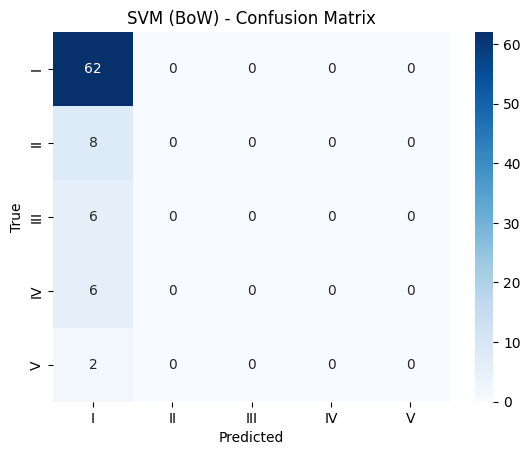

In [ ]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(svm_bow_plain,  X_train, y_train, X_test, y_test, "SVM (BoW)", RESULTS)


SVM (TF-IDF) Results
Train Accuracy: 0.991
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



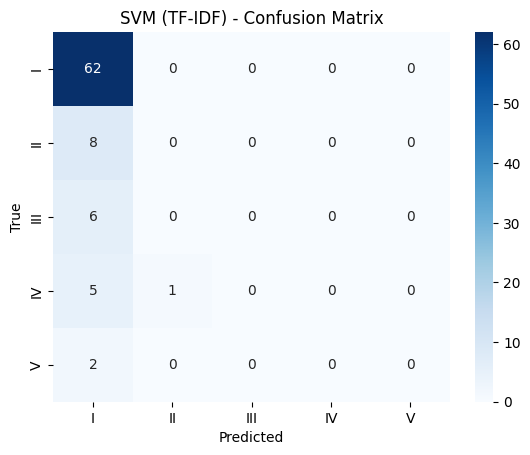

In [ ]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(svm_tfidf_plain,X_train, y_train, X_test, y_test, "SVM (TF-IDF)", RESULTS)


SVM (BoW + Oversample) Results
Train Accuracy: 0.958
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



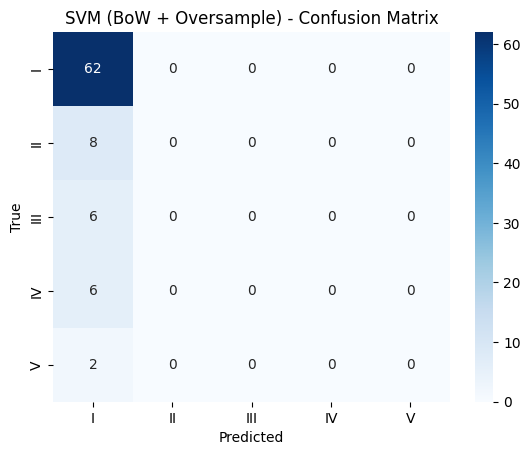

In [ ]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(svm_bow_overs,  X_train, y_train, X_test, y_test, "SVM (BoW + Oversample)", RESULTS)


SVM (TF-IDF + Oversample) Results
Train Accuracy: 0.991
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



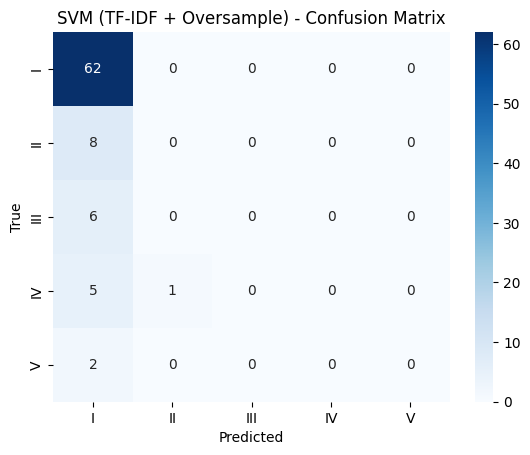

In [ ]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(svm_tfidf_overs,X_train, y_train, X_test, y_test, "SVM (TF-IDF + Oversample)", RESULTS)

In [ ]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline

# Define SVM model
svm_gamma = SVC(kernel='poly', degree=3, gamma=0.3,C=0.1, random_state=RANDOM_STATE) # Added random_state for reproducibility

# Pipelines for SVM
svm_bow_plain_gamma = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", svm_gamma)
])

svm_tfidf_plain_gamma = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", svm_gamma)
])

svm_bow_overs_gamma = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", svm_gamma)
])

svm_tfidf_overs_gamma = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", svm_gamma)
])


SVM GAMMA (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



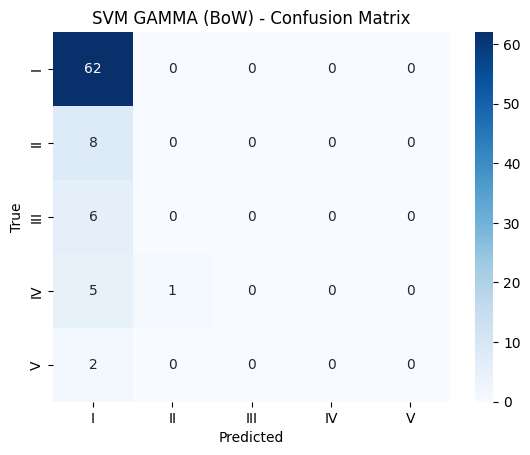

In [ ]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(svm_bow_plain_gamma,  X_train, y_train, X_test, y_test, "SVM GAMMA (BoW)", RESULTS)


SVM GAMMA (TF-IDF) Results
Train Accuracy: 0.740
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



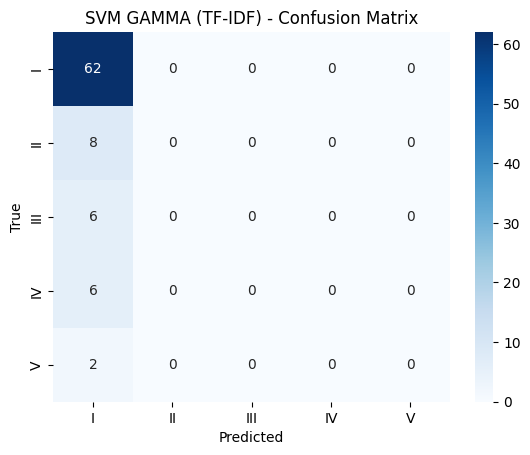

In [ ]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(svm_tfidf_plain_gamma,X_train, y_train, X_test, y_test, "SVM GAMMA (TF-IDF)", RESULTS)


SVM GAMMA (BoW + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



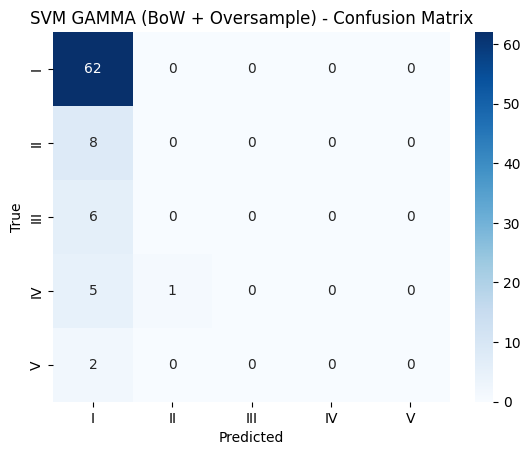

In [ ]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(svm_bow_overs_gamma,  X_train, y_train, X_test, y_test, "SVM GAMMA (BoW + Oversample)", RESULTS)


SVM (TF-IDF + Oversample) Results
Train Accuracy: 0.958
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



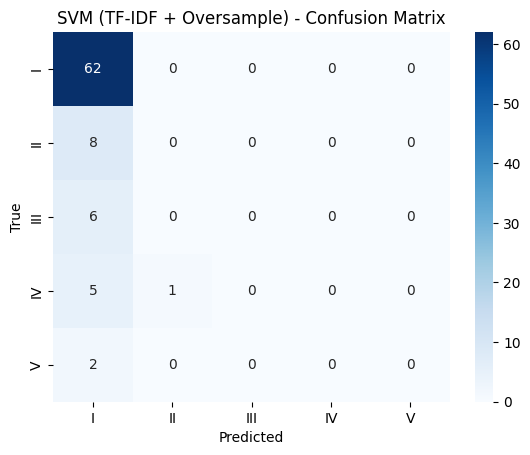

In [ ]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(svm_tfidf_overs_gamma,X_train, y_train, X_test, y_test, "SVM (TF-IDF + Oversample)", RESULTS)

In [ ]:
# Compare Results
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
9,SVM (TF-IDF + Oversample),0.991,0.738,0.171
8,SVM (BoW + Oversample),0.958,0.738,0.170
7,SVM (TF-IDF),0.991,0.738,0.171
6,SVM (BoW),0.850,0.738,0.170
10,SVM GAMMA (BoW),0.994,0.738,0.171
11,SVM GAMMA (TF-IDF),0.740,0.738,0.170
12,SVM GAMMA (BoW + Oversample),0.994,0.738,0.171
13,SVM (TF-IDF + Oversample),0.958,0.738,0.171


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### Base Model

#### 1. Random Forest with Bag-of-Words (BoW) - No Oversampling

In [ ]:
# Random Forest with Bag-of-Words (BoW) - No Oversampling
rf_bow_plain = ImbPipeline([
  ("bow", bow_vectorizer),
  ("clf", RandomForestClassifier(
      n_estimators=100,
      class_weight="balanced",
      random_state=RANDOM_STATE,
      n_jobs=-1
  ))
])

#### 2. Random Forest with TF-IDF - No Oversampling

In [ ]:
# Random Forest with TF-IDF - No Oversampling
rf_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

#### 3. Random Forest with BoW + Oversampling

In [ ]:
# Random Forest with BoW + Oversampling
rf_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

#### 4. Random Forest with TF-IDF + Oversampling

In [ ]:
# Random Forest with TF-IDF + Oversampling
rf_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

#### Base Model Evaluation


Random Forest (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



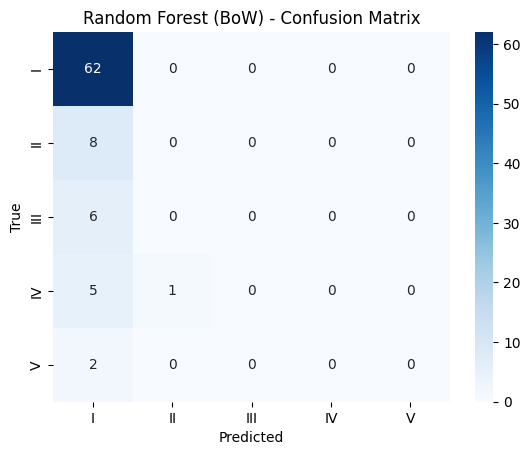

In [ ]:
# Evaluate Random Forest with Bag-of-Words (BoW) - No Oversampling
evaluate_and_log(rf_bow_plain, X_train, y_train, X_test, y_test, "Random Forest (BoW)", RESULTS)


Random Forest (TF-IDF) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



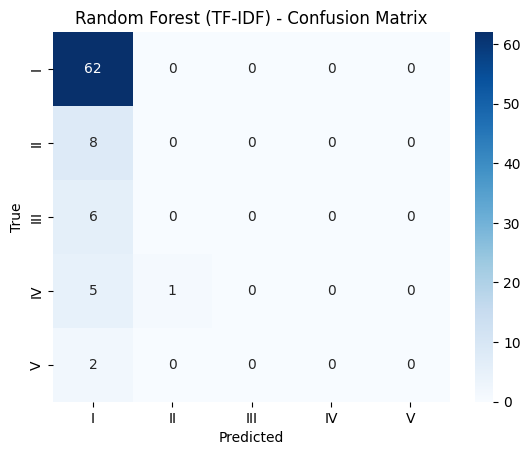

In [ ]:
# Evaluate Random Forest with TF-IDF - No Oversampling
evaluate_and_log(rf_tfidf_plain, X_train, y_train, X_test, y_test, "Random Forest (TF-IDF)", RESULTS)


Random Forest (BoW + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.172

              precision    recall  f1-score   support

           I      0.756     1.000     0.861        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.151     0.200     0.172        84
weighted avg      0.558     0.738     0.636        84



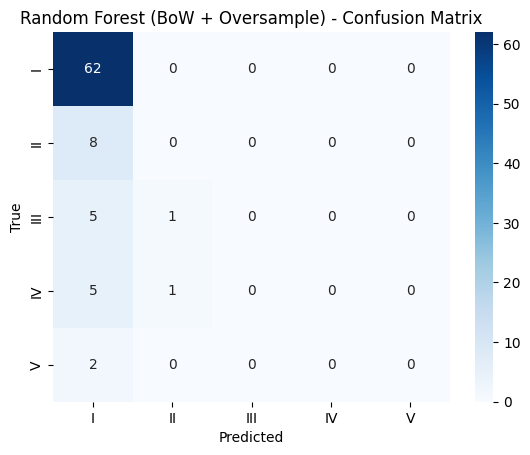

In [ ]:
# Evaluate Random Forest with BoW + Oversampling
evaluate_and_log(rf_bow_overs, X_train, y_train, X_test, y_test, "Random Forest (BoW + Oversample)", RESULTS)


Random Forest (TF-IDF + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.726
Test  Macro-F1: 0.169

              precision    recall  f1-score   support

           I      0.744     0.984     0.847        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.726        84
   macro avg      0.149     0.197     0.169        84
weighted avg      0.549     0.726     0.625        84



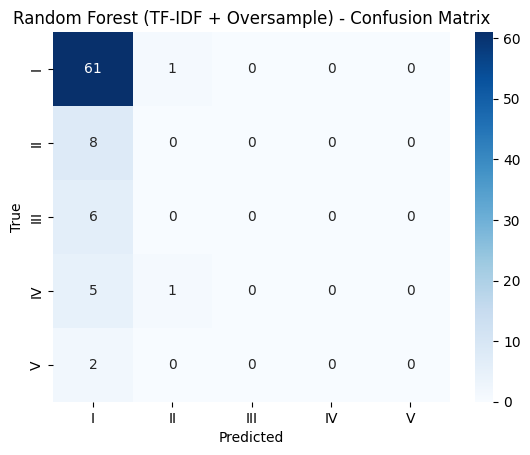

In [ ]:
# Evaluate Random Forest with TF-IDF + Oversampling
evaluate_and_log(rf_tfidf_overs, X_train, y_train, X_test, y_test, "Random Forest (TF-IDF + Oversample)", RESULTS)

#### Hyperparameter Tuning

In [ ]:
# Utility method to build Random Forest pipeline
def build_rf_pipeline(vectorizer):
    return ImbPipeline([
        (vectorizer.__class__.__name__.lower(), vectorizer),
        ("oversample", sampler),
        ("clf", RandomForestClassifier(
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])


In [ ]:
# Hyper Parameters to be tuned
rf_grid = {
  "clf__n_estimators": [100, 200, 300],
  "clf__max_depth": [None, 10, 20],
  "clf__min_samples_leaf": [1, 2, 4],
  "clf__max_features": ["sqrt", "log2"]
}

#### 1. Hyperparameter Tuning for Random Forest with BoW

In [ ]:
# Build Random Forest pipeline with BoW vectorization
pipe_rf_bow = build_rf_pipeline(bow_vectorizer)

# Set up GridSearchCV for Random Forest with BoW
grid_rf_bow = GridSearchCV(
    estimator=pipe_rf_bow,
    param_grid=rf_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)

# Run the grid search on the training data
grid_rf_bow.fit(X_train, y_train)

print("Best BoW params:", grid_rf_bow.best_params_, "CV Macro-F1:", round(grid_rf_bow.best_score_, 3))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best BoW params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200} CV Macro-F1: 0.731


#### 2. Hyperparameter Tuning for Random Forest with TF-IDF

In [ ]:
# Build Random Forest pipeline with TF-IDF vectorization
pipe_rf_tfidf = build_rf_pipeline(tfidf_vectorizer)

# Set up GridSearchCV for Random Forest with TF-IDF
grid_rf_tfidf = GridSearchCV(
    estimator=pipe_rf_tfidf,
    param_grid=rf_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)


# Run the grid search on the training data
grid_rf_tfidf.fit(X_train, y_train)

print("Best BoW params:", grid_rf_tfidf.best_params_, "CV Macro-F1:", round(grid_rf_tfidf.best_score_, 3))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best BoW params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200} CV Macro-F1: 0.731


#### Tuned Model Evaluation


Random Forest (BoW + TUNED) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.172

              precision    recall  f1-score   support

           I      0.756     1.000     0.861        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.151     0.200     0.172        84
weighted avg      0.558     0.738     0.636        84



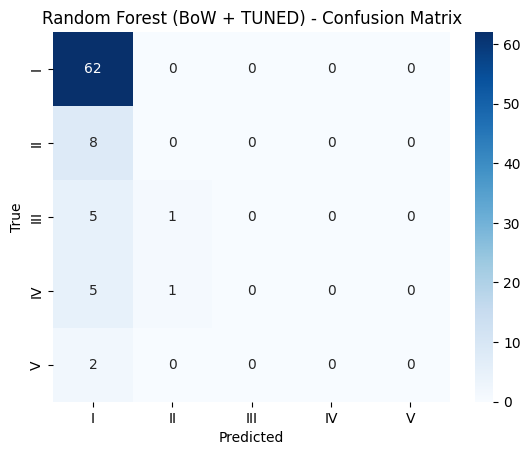

In [ ]:
#Evaluate Random Forest with BOW + Tuned
evaluate_and_log(grid_rf_bow.best_estimator_,   X_train, y_train, X_test, y_test,
                     "Random Forest (BoW + TUNED)", RESULTS)


Random Forest (TF-IDF + TUNED) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



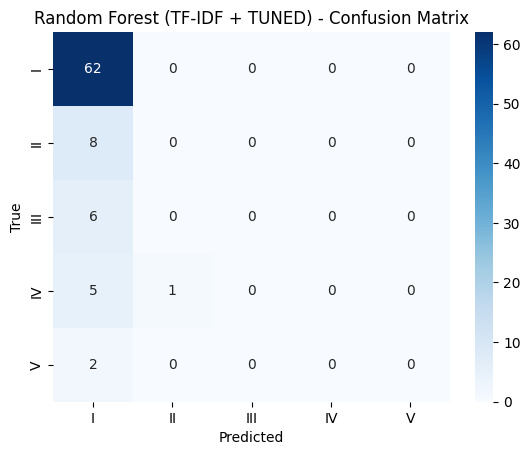

In [ ]:
#Evaluate Random Forest with TF-IDF + Tuned
evaluate_and_log(grid_rf_tfidf.best_estimator_,   X_train, y_train, X_test, y_test,
                     "Random Forest (TF-IDF + TUNED)", RESULTS)

XGBoost  model

In [ ]:
# import xgboost
import xgboost as xgb

In [ ]:
# creating Bag of Words
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(data['final_cleaned_text'])
bow_df = pd.DataFrame(bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.index = data.index
bow_df.head()

,00,001,007,01,018,0183,02,020,02bp0166,02bp0167,...,young,z014,zaf,zamac,zaro,zero,zinc,zinco,zn,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# creating tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(data['final_cleaned_text'])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.index = data.index
tfidf_df.head()

,00,001,007,01,018,0183,02,020,02bp0166,02bp0167,...,young,z014,zaf,zamac,zaro,zero,zinc,zinco,zn,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.185663,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Train Test Split for BoW
X = bow_df
y = data['Accident Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# train XG Boost classifier on BoW
from sklearn.preprocessing import LabelEncoder
# Create and fit label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost with encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions and decode them back to original labels
y_pred_encoded = xgb_classifier.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

XGboost_BoW_accuracy=accuracy_score(y_test, y_pred)
print("\nAccuracy Score:", XGboost_BoW_accuracy)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy Score: 0.7142857142857143


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.714
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           0      0.759     0.968     0.851        62
           1      0.000     0.000     0.000         8
           2      0.000     0.000     0.000         6
           3      0.000     0.000     0.000         6
           4      0.000     0.000     0.000         2

    accuracy                          0.714        84
   macro avg      0.152     0.194     0.170        84
weighted avg      0.561     0.714     0.628        84



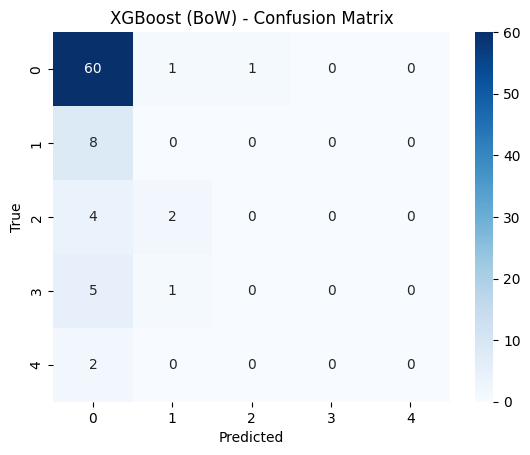

In [ ]:
#Evaluate XGBoost with BoW
evaluate_and_log(xgb_classifier, X_train, y_train_encoded, X_test, y_test_encoded,
                     "XGBoost (BoW)", RESULTS)

In [ ]:
# Train Test Split for tfidf

X = tfidf_df
y = data['Accident Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# train XG Boost classifier on TF-IDF

# Create and fit label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost with encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions and decode them back to original labels
y_pred_encoded = xgb_classifier.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

XGboost_TFIDF_accuracy=accuracy_score(y_test, y_pred)
# Print metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=0))
print("\nAccuracy Score:", XGboost_TFIDF_accuracy)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[58  4  0  0  0]
 [ 8  0  0  0  0]
 [ 5  1  0  0  0]
 [ 4  2  0  0  0]
 [ 2  0  0  0  0]]

Classification Report:
               precision    recall  f1-score   support

           I       0.75      0.94      0.83        62
          II       0.00      0.00      0.00         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.69        84
   macro avg       0.15      0.19      0.17        84
weighted avg       0.56      0.69      0.62        84


Accuracy Score: 0.6904761904761905


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (TF-IDF) Results
Train Accuracy: 0.997
Test  Accuracy: 0.690
Test  Macro-F1: 0.167

              precision    recall  f1-score   support

           0      0.753     0.935     0.835        62
           1      0.000     0.000     0.000         8
           2      0.000     0.000     0.000         6
           3      0.000     0.000     0.000         6
           4      0.000     0.000     0.000         2

    accuracy                          0.690        84
   macro avg      0.151     0.187     0.167        84
weighted avg      0.556     0.690     0.616        84



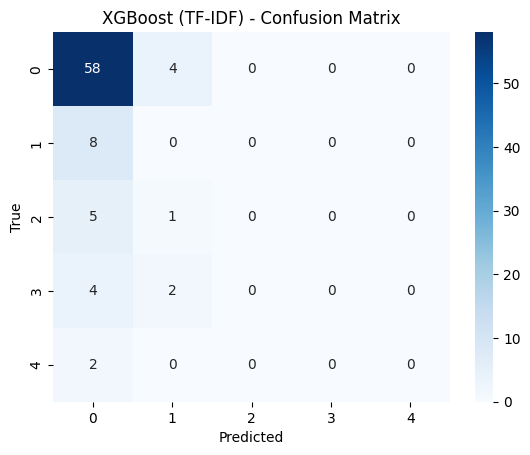

In [ ]:
#Evaluate XGBoost with BoW
evaluate_and_log(xgb_classifier, X_train, y_train_encoded, X_test, y_test_encoded,
                     "XGBoost (TF-IDF)", RESULTS)

In [ ]:
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
9,SVM (TF-IDF + Oversample),0.991,0.738,0.171
8,SVM (BoW + Oversample),0.958,0.738,0.170
7,SVM (TF-IDF),0.991,0.738,0.171
6,SVM (BoW),0.850,0.738,0.170
14,Random Forest (BoW),0.994,0.738,0.171
15,Random Forest (TF-IDF),0.994,0.738,0.171
16,Random Forest (BoW + Oversample),0.994,0.738,0.172
18,Random Forest (BoW + TUNED),0.994,0.738,0.172
